# AVISO Inversion with all data and swath data, no error

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, build_h_matrix
from aviso_rossby_wave import reverse_vector, forecast_ssh
from aviso_rossby_wave import build_swath, inversion, inversion2, make_error_over_time

## Model coefficients such as starting date, number of waves etc.

In [2]:
alpha_std = np.arange(5e-4, 3.05e-2, 1e-3) # standard deviation of error paramters
alpha_std 

array([0.0005, 0.0015, 0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075,
       0.0085, 0.0095, 0.0105, 0.0115, 0.0125, 0.0135, 0.0145, 0.0155,
       0.0165, 0.0175, 0.0185, 0.0195, 0.0205, 0.0215, 0.0225, 0.0235,
       0.0245, 0.0255, 0.0265, 0.0275, 0.0285, 0.0295])

In [3]:
day0, day1 = 0, 40 # 
Tdim = day1 - day0
time_range = (day1 - day0) * 2
start_date = '2016-01-01' ## starting date
n_waves = '190' #number of waves
exp = 2 # P_over_R = K^-1
mu, sigma = 0, alpha_std[3] # std of error amp

## Subset 10 degree by 10 degree of ocean

In [4]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [5]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]

In [6]:
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
date_time = avisso_ds.date_time.data[day0:]

In [7]:
SSHA = SSHA - SSHA.mean(axis = -1) # - SSHA.mean(axis = 0)

In [8]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

#### Rossby wave vertical modes

In [10]:
MModes = 1

### Inversion with selecetd swath data points

In [11]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

### parameters

In [12]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
Psi = strat_ds.Psi.data

#### Rossby wave estimate

In [13]:
# wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date + '_' + n_waves + 'waves.nc') # forward model - filtered AVISO
wave_ds =  xr.open_dataset('rossby_wave_estimate_2016-01-01_190waves_data40days.nc')

In [14]:
l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

In [15]:
l_n = l_n_orig.reshape(len(l_n_orig), MModes)
k_n = k_n_orig.reshape(len(k_n_orig), MModes)

#### assimilate multiple days of data

In [18]:
MSLA0 = wave_ds.MSLA_forward.data[:, :, day0:day1] # Filtered SSH

In [19]:
### assess skill, get indices
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

#### Number of models/waves

In [20]:
M = k_n.size * l_n.size

#### Plot skill matrix

In [21]:
kk, ll = np.meshgrid(k_n, l_n)

#### Build basis function H matrix

In [23]:
dlon = lon - lon.mean()
dlat = lat - lat.mean()
    
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
omega = np.zeros([len(k_n), len(l_n), MModes])

nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
            for count in range(len(Iindex)):
                # (data, model)
                H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
                H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
            nn += 1

H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_6062/1524257252.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)


#### signal to noise ratio

Signal to noise ratio decreases in proportion to $k^{-1}$

In [24]:
counter = 0
exp = -2
ssh_std = .1
k0 = l_n.max() # flat at or below k0 

p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
counter = 0
R = 0.01 # noise = 1. cm

for kk in l_n:
    for ll in k_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

P_matrix = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(P_matrix[:],  R / p_diagonal / p_factor)

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_6062/1271296567.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_6062/1271296567.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


#### build satellite swath

In [26]:
swath_width, x_swath = 6, 20
days = np.arange(day0, day1)

In [27]:
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

#### Add errors to the swaths

In [28]:
time_factor = np.arange(1, 1 + day1-day0)

In [30]:
# generate error parameter with Gaussian distribution 
alpha = np.zeros([Tdim, 7, 2]) #np.random.normal(mu, sigma, Tdim * 7).reshape(Tdim, 7) #
for nn in range(7):
    alpha[:, nn:nn+1,:] = np.random.normal(mu, sigma, [Tdim,1,2]) #TEST

In [32]:
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

In [34]:
# Compute the RMS for each variable
rms_timing_err = np.sqrt(np.mean(timing_err_valid**2))
rms_roll_err = np.sqrt(np.mean(roll_err_valid**2))
rms_baseline_dilation_err = np.sqrt(np.mean(baseline_dilation_err_valid**2))
rms_phase_err = np.sqrt(np.mean(phase_err_valid**2))
rms_timing_err, rms_roll_err, rms_baseline_dilation_err, rms_phase_err

(0.003378283521792276,
 0.006601878990816529,
 0.012937856965189563,
 0.006731988489873236)

#### sample SSH, errors and add white noise 

In [35]:
IND_TIMINGl = -7 -7
IND_ROLLl = -6 -7
IND_BASELINEl = -5 -7
IND_PHASE3l, IND_PHASE4l, IND_PHASE5l, IND_PHASE6l = -4 -7, -3-7, -2-7, -1-7

IND_TIMINGr = -7 
IND_ROLLr = -6
IND_BASELINEr = -5
IND_PHASE3r, IND_PHASE4r, IND_PHASE5r, IND_PHASE6r = -4, -3, -2, -1

#### Sub-sample the SSH, correlated errors and H matrix

In [37]:
#### Sub-sample the SSH, correlated errors and H matrix
N = len(tindex) # number of data
MSLA_swath = np.zeros(N)
M = l_n.size * k_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([N, 2 * (M + Tdim * 7)]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
counter = 0
mask=np.zeros([MSLA_fwd.shape[0],MSLA_fwd.shape[1],MSLA_fwd.shape[2]])

for ii in range(N):
    IIndex[ii] = nx * ny * tindex[ii] + xvalid_index[ii] + nx*yvalid_index[ii] # index in the vector space
    ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
    cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
    MSLA_swath[ii] = ssh[ii] + cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
    mask[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]=1
    for nn in range(M):
        JIndex = 2 * MModes * nn # +  2 * mm # Model space
        H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

# Important parameter: Root mean squared correlated error and ssh

In [38]:
rms_err = np.sqrt(np.mean(cor_err**2))
rms_ssh = np.sqrt(np.mean(ssh**2))

(0.016018481689884644, 0.05476211724585239, 29.251026979052497)

In [39]:
left_valid = len(yswath_index_left.compressed().astype(int))
right_valid = len(yswath_index_right.compressed().astype(int)) 

Valid_points = len(xvalid_index) // Tdim
err_basis_func = np.zeros([Valid_points, 7*2])

# since satellite tracks are the same for each day in this idealized case, don't loop through time steps
# if time did progress, we would need to loop through carefully to build matrix for each day
tt=0
for ii in range(left_valid):
    #timing error
    err_basis_func[ii, IND_TIMINGl] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    err_basis_func[ii, IND_ROLLl] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    err_basis_func[ii, IND_BASELINEl] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
    H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
    err_basis_func[ii, IND_PHASE3l] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    err_basis_func[ii, IND_PHASE4l] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    err_basis_func[ii, IND_PHASE5l] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    err_basis_func[ii, IND_PHASE6l] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
    
for ii in range(left_valid,Valid_points):
    #timing error
    err_basis_func[ii, IND_TIMINGr] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    err_basis_func[ii, IND_ROLLr] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    err_basis_func[ii, IND_BASELINEr] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
    H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
    err_basis_func[ii, IND_PHASE3r] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    err_basis_func[ii, IND_PHASE4r] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    err_basis_func[ii, IND_PHASE5r] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    err_basis_func[ii, IND_PHASE6r] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

In [40]:
err_basis_func1=err_basis_func

((450, 14), (40, 450), 40, (40, 450))

In [41]:
### fill the error basis function part of the H matrix
for tt in range(Tdim):
    H_swath[tt*Valid_points:(tt+1)*Valid_points, 2 * M + tt * 7*2 : 2 * M + (tt+1) * 7*2] = err_basis_func

#### signal to noise ratio - R/P

In [42]:
counter = 0
exp = -2
ssh_std = .1
k0 = l_n.max() # flat at or below k0 
p_diagonal = np.zeros([2 * M + Tdim * 7*2])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
counter = 0
R = 0.01 # noise = 10. cm (0.1 m), variance = 0.01 m^2

for kk in l_n:
    for ll in k_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter] + k0) ** exp  * p_factor
        p_diagonal[2 * counter + 1] = (kl[counter] + k0) ** exp  * p_factor
        counter += 1   

p_diagonal[2*M:] = sigma ** 2 # errors

P_matrix = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])

np.fill_diagonal(P_matrix[:],  R / p_diagonal )

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_6062/1931342398.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_6062/1931342398.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


In [43]:
Y_vector = Y_v #.flatten()# Reshape Y_v to a 1D array
H_matrix = H_swath #.reshapezz((Tdim * Valid_points, 2 * M + Tdim * 7*2))

#### diagnostics: fit error to error basis functions

#### Solve for amplitudes

In [44]:
amp_swath, msla_estimated_swath = inversion(MSLA_swath, H_swath, P_matrix) # assimilate the filtered AVISO SSH + error

#### estimate the errors and ssh : H * amp

In [46]:
err_est_1step = np.matmul(H_matrix[:, -14*Tdim:], amp_swath[-14*Tdim:])
ssh_est_1step = np.matmul(H_matrix[:, :-14*Tdim], amp_swath[:-14*Tdim])

# Important result: error estimate skill and ssh estimate skill of the entire time series

In [198]:
ssh_diff = ssh_est_1step - ssh
err_diff = err_est_1step - cor_err
ssh_diff1 = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
err_diff1  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

#### Make predictions of SSH based on the estimated amplitudes:
#### Swath data, with errors

#### True and estimated SSH and Errors

In [203]:
err_map1 = np.zeros([len(lat), len(lon), Tdim])
ssh_map1 = np.zeros([len(lat), len(lon), Tdim])
ssh_true1 = np.zeros([len(lat), len(lon), Tdim])
err_true1 = np.zeros([len(lat), len(lon), Tdim])
lon_valid = np.ma.masked_all([len(lat), len(lon), Tdim])
lat_valid = np.ma.masked_all([len(lat), len(lon), Tdim])
for ii, idx in enumerate(xvalid_index):
    tt=tindex[ii].astype(int)
    err_map1[yvalid_index[ii], xvalid_index[ii], tt] = err_est_1step[ii] 
    ssh_map1[yvalid_index[ii], xvalid_index[ii], tt]  = ssh_est_1step[ii]
    err_true1[yvalid_index[ii], xvalid_index[ii], tt] = cor_err[ii]
    ssh_true1[yvalid_index[ii], xvalid_index[ii], tt] = ssh[ii]
    lon_valid[yvalid_index[ii], xvalid_index[ii], tt] = lon[xvalid_index[ii]]
    lat_valid[yvalid_index[ii], xvalid_index[ii], tt] = lat[yvalid_index[ii]]

#### Reverse the vectorization on the swaths

In [204]:
ssh_diff1=np.zeros([Tdim])
err_diff1=np.zeros([Tdim])
nslice=450
for tt in range(Tdim):
    ssh_diff = ssh_est_1step[tt*nslice:(tt+1)*nslice] - ssh[tt*nslice:(tt+1)*nslice]
    err_diff = err_est_1step[tt*nslice:(tt+1)*nslice] - cor_err[tt*nslice:(tt+1)*nslice]
    ssh_diff1[tt] = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
    err_diff1[tt]  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

In [205]:
err_diff1, err_est_1step.size/450

(array([0.08325742, 0.16734814, 0.05970828, 0.19373414, 0.07169984,
        0.13089865, 0.0823235 , 0.1436776 , 0.19697371, 0.20359623,
        0.18387618, 0.07890545, 0.04346078, 0.08844951, 0.08743346,
        0.07771677, 0.06064431, 0.04178817, 0.07593859, 0.10503336,
        0.16481341, 0.16746684, 0.36471965, 0.13191878, 0.02894999,
        0.06621644, 0.10614812, 0.128061  , 0.141882  , 0.05780578,
        0.06117832, 0.0468908 , 0.08038943, 0.07707566, 0.09593205,
        0.07920311, 0.11446008, 0.09493525, 0.0906246 , 0.03247914]),
 40.0)

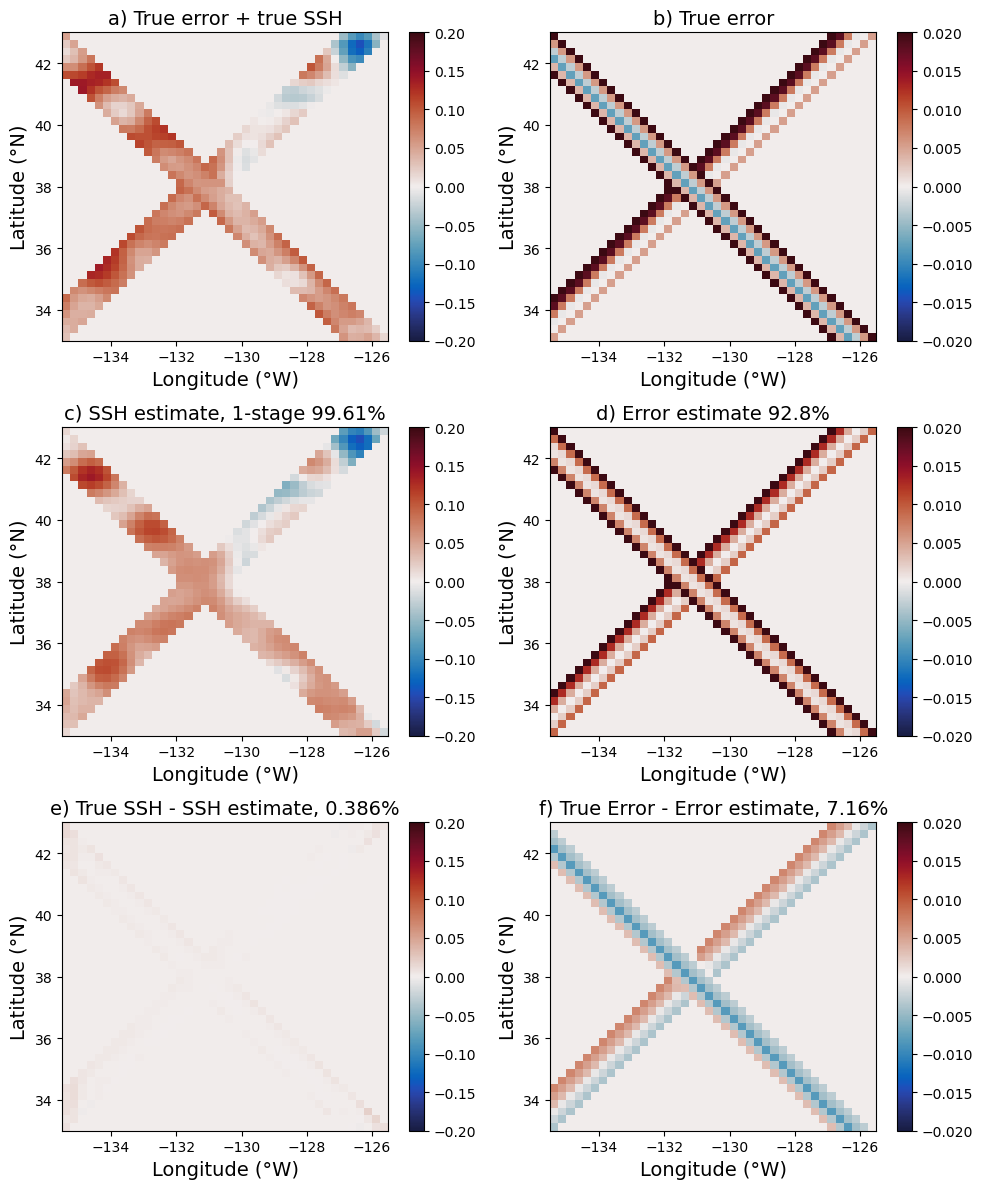

In [206]:
fig = plt.figure(figsize = (10, 12))

n=4
plt.subplot(321)
plt.pcolormesh(lon, lat, err_true1[:,:,n] + ssh_true1[:,:,n], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True error + true SSH', fontsize = 14)


plt.subplot(323)
plt.pcolormesh(lon, lat, ssh_map1[:,:,n], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) SSH estimate, 1-stage ' + str((1- ssh_diff1[n]) * 100)[:5] + '%', fontsize = 14)

plt.subplot(325)
plt.pcolormesh(lon, lat, ssh_true1[:,:,n] - ssh_map1[:,:,n], cmap = cmo.cm.balance,  vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('e) True SSH - SSH estimate, ' + str(ssh_diff1[n] * 100)[:5] + '%', fontsize = 14)

plt.subplot(322)
plt.pcolormesh(lon, lat, err_true1[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) True error', fontsize = 14)

plt.subplot(324)
plt.pcolormesh(lon, lat, err_map1[:,:,n], cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) Error estimate ' +  str((1- err_diff1[n]) * 100)[:4] + '%', fontsize = 14)

plt.subplot(326)
plt.pcolormesh(lon, lat, err_true1[:,:,n] - err_map1[:,:,n], cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('f) True Error - Error estimate, ' + str(err_diff1[n] * 100)[:4] + '%' , fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(date_time[0])[:10] + '_1stage.png', dpi = 300)

In [207]:
err_diff1.shape

(40,)

Text(0.5, 1.0, 'c) true SSH')

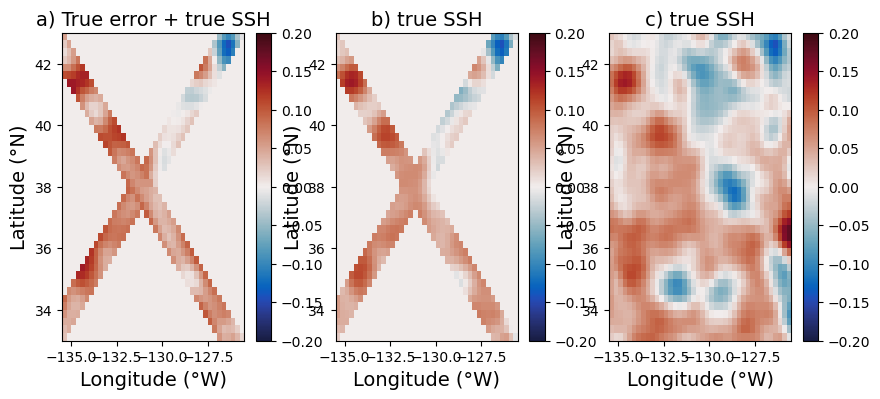

In [140]:
fig = plt.figure(figsize = (10, 4))

n=4
plt.subplot(131)
plt.pcolormesh(lon, lat, err_true1[:,:,n] + ssh_true1[:,:,n], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True error + true SSH', fontsize = 14)

plt.subplot(132)
plt.pcolormesh(lon, lat, ssh_true1[:,:,n], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) true SSH', fontsize = 14)

plt.subplot(133)
plt.pcolormesh(lon, lat, MSLA_fwd[:,:,n], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) true SSH', fontsize = 14)

#### Make predictions of SSH based on the estimated amplitudes:
#### is the extrapolation skill good?

In [208]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
residual_iter = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range):
    print(date_time[day])
    MSLA = MSLA_fwd[:, :, day:day+1] 
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0 - day0 + day)
    SSHA_predicted[day], SSHA_true[day], residual_iter[day] = forecast_ssh(MSLA, amp_swath[:380], H_all)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
#     plt.figure(figsize = (15, 5))

#     plt.subplot(131)
#     plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

#     plt.subplot(132)
#     plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('b) 1-stage inversion, swath data', fontsize = 14)

#     residual = MSLA[:, :, 0] - MSLA_inverse[:, :, day] 
#     plt.subplot(133)
#     plt.plot(lon_valid, lat_valid, 'x', color = 'gray')
#     plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('c) Residual variance ' +  str(residual_iter[day] * 100)[:4] + '%', fontsize = 14)
    
#     plt.tight_layout()
#     #plt.close()
#     plt.savefig('inversion/ssh_1step_' + str(date_time[day])[:10] +'_' + str(skill.size) + 'waves.png', dpi = 300)

2016-01-01T00:00:00.000000000
2016-01-02T00:00:00.000000000
2016-01-03T00:00:00.000000000
2016-01-04T00:00:00.000000000
2016-01-05T00:00:00.000000000
2016-01-06T00:00:00.000000000
2016-01-07T00:00:00.000000000
2016-01-08T00:00:00.000000000
2016-01-09T00:00:00.000000000
2016-01-10T00:00:00.000000000
2016-01-11T00:00:00.000000000
2016-01-12T00:00:00.000000000
2016-01-13T00:00:00.000000000
2016-01-14T00:00:00.000000000
2016-01-15T00:00:00.000000000
2016-01-16T00:00:00.000000000
2016-01-17T00:00:00.000000000
2016-01-18T00:00:00.000000000
2016-01-19T00:00:00.000000000
2016-01-20T00:00:00.000000000
2016-01-21T00:00:00.000000000
2016-01-22T00:00:00.000000000
2016-01-23T00:00:00.000000000
2016-01-24T00:00:00.000000000
2016-01-25T00:00:00.000000000
2016-01-26T00:00:00.000000000
2016-01-27T00:00:00.000000000
2016-01-28T00:00:00.000000000
2016-01-29T00:00:00.000000000
2016-01-30T00:00:00.000000000
2016-01-31T00:00:00.000000000
2016-02-01T00:00:00.000000000
2016-02-02T00:00:00.000000000
2016-02-03

In [209]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse  = np.zeros(time_range)
MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])

ind_list = list('abcdefghijklm')
count = 0
plt.figure(figsize = (15, 12))
for day in range(time_range):
    # SSH data
    MSLA = MSLA_fwd[:, :, day0+day: day0+day+1]
    # Build basis function H matrix
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0 - day0 + day)
    # forecast SSH
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(MSLA, amp_swath[:380],  H_all)
    # reverse vector
    MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
#     if (day % 4 ==0):
#         plt.subplot(3, 3, count + 1)
#         plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.2, vmax = .2) 
#         plt.colorbar()
#         plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#         plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#         plt.title(ind_list[count] + ') AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

#         plt.subplot(3, 3, count + 2)
#         plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
#         plt.colorbar()
#         plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#         plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#         plt.title(ind_list[count+1] + ') 1-stage inversion with swath data', fontsize = 14)

#         residual = MSLA[:, :, 0] - MSLA_fwrd[:, :, day] 
#         plt.subplot(3, 3, count + 3)
#         plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
#         plt.colorbar()
#         plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#         plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#         plt.title(ind_list[count+2] +') Residual variance ' 
#                   + str((variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
#         count = count + 3
#         plt.tight_layout()

# plt.savefig('./ssh_swath' + str(date_time[day0 + day])[:10] +'_' + str(skill.size) + 'waves_1stage.png', dpi = 300)

<Figure size 1500x1200 with 0 Axes>

In [210]:
# compute residual variance in and out of track
var_in=np.zeros(time_range)
var_out=np.zeros(time_range)
for i in range(time_range):
    msla_in=np.ma.masked_where(mask[:,:,0]==0,MSLA_fwd[:,:,i])
    msla_out=np.ma.masked_where(mask[:,:,0]==1,MSLA_fwd[:,:,i])
    var_in[i]=np.mean(np.mean((MSLA_fwrd[:,:,i] - msla_in)**2,axis=1),axis=0)/(np.mean(np.mean(msla_in**2,axis=1),axis=0))
    var_out[i]=np.mean(np.mean((MSLA_fwrd[:,:,i] - msla_out)**2,axis=1),axis=0)/(np.mean(np.mean(msla_out**2,axis=1),axis=0))

In [211]:
# compute residual variance in and out of track
var_in_only=np.zeros(time_range)
for i in range(time_range):
    msla_in2 = np.ma.masked_where(mask[:,:,0]==0,MSLA_fwd[:,:,i])
    var_in_only[i]=np.mean(np.mean((ssh_map1[:,:,i] - msla_in2)**2,axis=1),axis=0)/(np.mean(np.mean(msla_in2**2,axis=1),axis=0))

IndexError: index 40 is out of bounds for axis 2 with size 40

In [ ]:
z=np.ma.masked_where(mask[:,:,0]==0,MSLA_fwd[:,:,0])
np.ma.compressed(z).shape

###  Ambiguity test 

#### basis function correlation matrix: assessing whether the basis functions are orthogonal

In [ ]:
# import pandas as pd
# import seaborn as sns
# # collect data
# data = H_matrix[:, -7:]
# # form dataframe
# dataframe = pd.DataFrame(data, columns=['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# cov_matrix = dataframe.cov()

In [ ]:
# corr_matrix = dataframe.corr()

In [ ]:
# plt.figure(figsize = (10, 8))
# sns.heatmap(corr_matrix, annot = True, cmap = cmo.cm.balance, vmin = -1, vmax = 1)
# plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# plt.title('Basis Function Correlation Matrix', fontsize = 14)
# plt.savefig('./H_corr_matrix.png')

#### the proterier covariance matrix of the difference between the estimated and the true model parameters is

In [ ]:
# HTH = np.matmul(H_matrix[:, -Tdim*2*7:].T, H_matrix[:, -Tdim*2*7:])

# HRH = HTH + P_matrix[-Tdim*2*7:, -Tdim*2*7:] #0.81 * sigma #, P: uncertainty in model, R: uncertainty in data

# COV = LA.inv(HRH + LA.inv(P_matrix[-Tdim*2*7:, -Tdim*2*7:]))

In [ ]:
# def correlation_from_covariance(covariance):
    
#     v = np.sqrt(np.diag(covariance))
#     outer_v = np.outer(v, v)
#     correlation = covariance / outer_v
#     correlation[covariance == 0] = 0
    
#     return correlation

In [ ]:
# COR = correlation_from_covariance(COV)

In [ ]:
# plt.figure(figsize = (10, 8))
# sns.heatmap(COV, annot = True, cmap = cmo.cm.balance, vmin = -.05, vmax = .05)
# plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# #plt.title('Model Parameter Covariance Matrix $<(x-\hat{x})(x-\hat{x})^T> = (H^{T}R^{-1}H + P^{-1})^{-1}$', fontsize = 14)
# plt.title('Model Parameter Covariance Matrix $<(x-\hat{x})(x-\hat{x})^T> $', fontsize = 14)
# plt.savefig('./cov_matrix.png')

In [ ]:
# plt.figure(figsize = (10, 8))
# sns.heatmap(COV, annot = True, cmap = cmo.cm.balance, vmin = -.05, vmax = .05)
# plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# #plt.title('Model Parameter Covariance Matrix $<(x-\hat{x})(x-\hat{x})^T> = (H^{T}R^{-1}H + P^{-1})^{-1}$', fontsize = 14)
# plt.title('Model Parameter Covariance Matrix $<(x-\hat{x})(x-\hat{x})^T> $', fontsize = 14)
# plt.savefig('./cov_matrix.png')

In [ ]:
# plt.figure(figsize = (10, 8))

# sns.heatmap(COR, annot = True, cmap = cmo.cm.balance, vmin = -.75, vmax = .75)
# plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
# plt.title('Model Parameter Correlation Matrix $(H^{T}R^{-1}H + P^{-1})^{-1}$', fontsize = 14)
# plt.savefig('./corr_matrix.png')

### Two-stage approach: reconstructing the SSH separately from solving the correlated error

#### First step: fit errors

#### Sub-sample the SSH, correlated errors and H matrix

In [ ]:
H_v1 = H_matrix[:, -7 * Tdim*2:]

In [ ]:
P_over_R1 = P_matrix[-7* Tdim*2:, -7* Tdim*2:]#.mean(axis = 0)

In [ ]:
HTH = np.matmul(H_v1.T, H_v1)

In [ ]:
HRH = HTH + P_over_R1 # P: uncertainty in model, R: uncertainty in data
D = np.matmul(LA.inv(HRH), H_v1.T)   

In [ ]:
amp_err = np.matmul(D, MSLA_swath)

#### correlated error estimate

In [ ]:
#### estimate the correlated error
err_est_2step = np.matmul(H_v1, amp_err)

#### SSH + correlated errors - estimated correlated errors

In [ ]:
tau_ssh = MSLA_swath - err_est_2step

#### second step: fit residual to rossby wave models

In [ ]:
H_v = H_swath[:, :-7 * Tdim*2]
HTH = np.matmul(H_v.T, H_v)
HRH = np.zeros(HTH.shape)
HRH = HTH +  P_matrix[:-7 * Tdim*2, :-7 * Tdim*2]
D = np.matmul(LA.inv(HRH), H_v.T)
eig, vec = LA.eig(HRH)

#### Soution with noise, 2 step approach

In [ ]:
amp_swath_2step = np.matmul(D, tau_ssh)

#### Prediction with new amplitudes in the next 40 days

In [ ]:
ssh_est_2step = np.matmul(H_v, amp_swath_2step)

# Important result: 2-stage error estimate skill and ssh estimate skill

In [ ]:
ssh_diff2=np.zeros([time_range])
err_diff2=np.zeros([time_range])
nslice=450
for tt in range(time_range):
    ssh_diff = ssh_est_2step[tt*nslice:(tt+1)*nslice] - ssh[tt*nslice:(tt+1)*nslice]
    err_diff = err_est_2step[tt*nslice:(tt+1)*nslice] - cor_err[tt*nslice:(tt+1)*nslice]
    ssh_diff2[tt] = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
    err_diff2[tt]  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

In [ ]:
plt.figure(figsize = (8, 8))
plt.subplot(311)
plt.plot(amp_swath[:], '*', label = 'amp estimate (1 step)')
plt.plot(np.append(amp[:], alpha), '.', label = 'true amp')
#plt.plot(np.sqrt(P_matrix.diagonal()[:]), label = 'Prior')
plt.ylabel('meters')
plt.legend()
plt.title('model parameters, err std' + str(sigma))

plt.subplot(312)
plt.plot(ssh[:nslice], label = 'ssh')
plt.plot(ssh_est_2step[:nslice], label = 'ssh estimate')
plt.legend()

plt.subplot(313)
plt.plot(cor_err[:nslice], label = ' true err')
plt.plot(err_est_2step[:nslice], label= ' estimate err')
plt.plot(cor_err[:nslice] - err_est_2step[:nslice], label= 'cor_err- estimate err')
plt.legend()
plt.tight_layout()
plt.savefig('ssh_err_est_err_std'+ str(sigma) +'.png')

In [ ]:
err_map2 = np.zeros([ny, nx, time_range])
ssh_true2 = np.zeros([ny, nx, time_range])
ssh_2step = np.zeros([ny, nx, time_range])
err_true2 = np.zeros([ny, nx, time_range])
for ii, idx in enumerate(xvalid_index):
    tt = tindex[ii].astype(int)
    err_map2[yvalid_index[ii], xvalid_index[ii], tt] = err_est_2step[ii] 
    ssh_true2[yvalid_index[ii], xvalid_index[ii], tt] = ssh[ii]
    err_true2[yvalid_index[ii], xvalid_index[ii], tt] = cor_err[ii]
    ssh_2step[yvalid_index[ii], xvalid_index[ii], tt] = ssh_est_2step[ii]

In [168]:
ssh_diff2=np.zeros([time_range])
err_diff2=np.zeros([time_range])
nslice=450
for tt in range(time_range):
    ssh_diff = ssh_est_2step[tt*nslice:(tt+1)*nslice] - ssh[tt*nslice:(tt+1)*nslice]
    err_diff = err_est_2step[tt*nslice:(tt+1)*nslice] - cor_err[tt*nslice:(tt+1)*nslice]
    ssh_diff2[tt] = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
    err_diff2[tt]  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

In [169]:
ssh_diff_2step = (np.mean((ssh_true2 - ssh_2step) ** 2 ))/ (np.mean((ssh_true2) ** 2 ))
err_diff_2step = (np.mean((err_true2 - err_map2) ** 2 ))/ (np.mean((err_true2) ** 2 ))

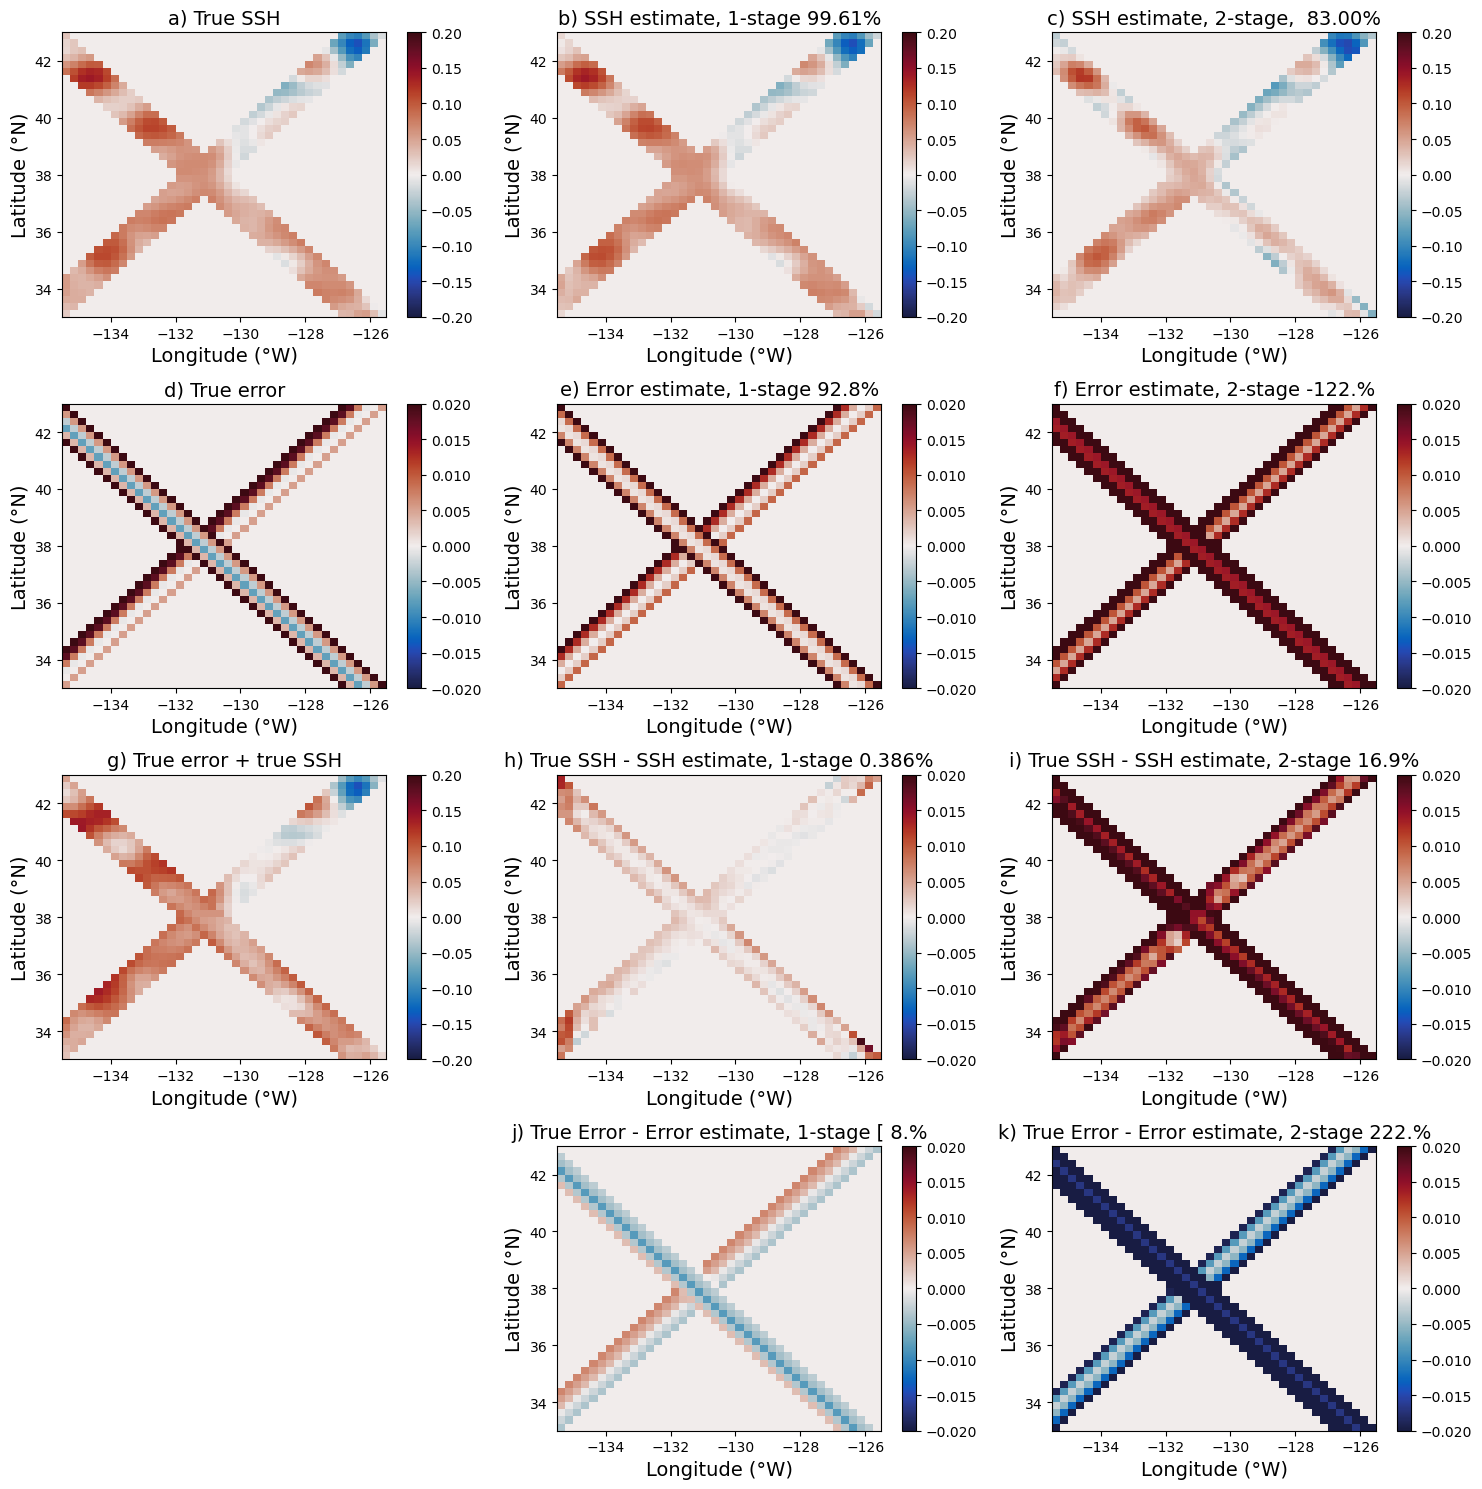

In [170]:
fig = plt.figure(figsize = (15, 15))

n=4
plt.subplot(431)
plt.pcolormesh(lon, lat, ssh_true1[:,:,n], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True SSH', fontsize = 14)


plt.subplot(432)
plt.pcolormesh(lon, lat, ssh_map1[:,:,n], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar() 
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) SSH estimate, 1-stage ' + str((1- ssh_diff1[n]) * 100)[:5] + '%', fontsize = 14)

plt.subplot(433)
plt.pcolormesh(lon, lat, ssh_2step[:,:,n], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) SSH estimate, 2-stage,  ' + str((1- ssh_diff_2step) * 100)[:5] + '%', fontsize = 14)

plt.subplot(434)
plt.pcolormesh(lon, lat, err_true1[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) True error', fontsize = 14)

plt.subplot(435)
plt.pcolormesh(lon, lat, err_map1[:,:,n], cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('e) Error estimate, 1-stage ' +  str((1- err_diff1[n]) * 100)[:4] + '%', fontsize = 14)

plt.subplot(436)
plt.pcolormesh(lon, lat, err_map2[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('f) Error estimate, 2-stage '+ str((1- err_diff_2step) * 100)[:5] + '%', fontsize = 14)

plt.subplot(437)
plt.pcolormesh(lon, lat, err_true1[:,:,n] + ssh_true1[:,:,n], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('g) True error + true SSH', fontsize = 14)

plt.subplot(438)
plt.pcolormesh(lon, lat, ssh_true1[:,:,n] - ssh_map1[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('h) True SSH - SSH estimate, 1-stage ' + str(ssh_diff1[n] * 100)[:5] + '%', fontsize = 14)

plt.subplot(4, 3, 9)
plt.pcolormesh(lon, lat, ssh_true2[:,:,n] - ssh_2step[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('i) True SSH - SSH estimate, 2-stage ' + str(ssh_diff_2step * 100)[:4]  + '%', fontsize = 14)

plt.subplot(4, 3, 11)
plt.pcolormesh(lon, lat, err_true1[:,:,n] - err_map1[:,:,n], cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('j) True Error - Error estimate, 1-stage ' + str(err_diff1 * 100)[:4] + '%' , fontsize = 14)

plt.subplot(4,3,12)
plt.pcolormesh(lon, lat, err_true2[:,:,n] - err_map2[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('k) True Error - Error estimate, 2-stage ' + str(err_diff_2step * 100)[:4] + '%' , fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(date_time[0])[:10] + '_1stage.png', dpi = 300)

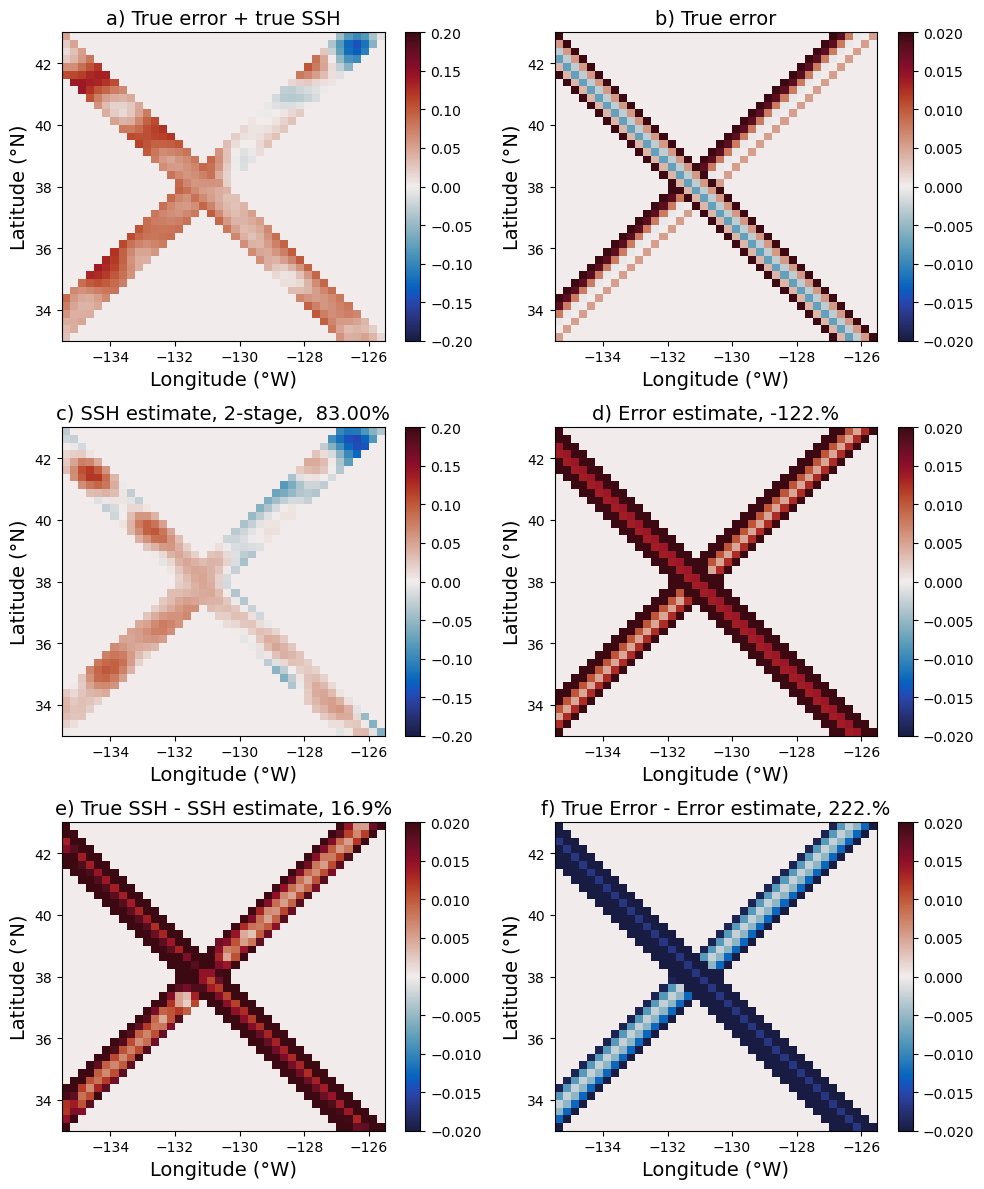

In [171]:
fig = plt.figure(figsize = (10, 12))


plt.subplot(321)
plt.pcolormesh(lon, lat, err_true1[:,:,n] + ssh_true1[:,:,n], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True error + true SSH', fontsize = 14)


plt.subplot(323)
plt.pcolormesh(lon, lat, ssh_2step[:,:,n], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) SSH estimate, 2-stage,  ' + str((1- ssh_diff_2step) * 100)[:5] + '%', fontsize = 14)

plt.subplot(325)
plt.pcolormesh(lon, lat, ssh_true2[:,:,n] - ssh_2step[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('e) True SSH - SSH estimate, ' + str(ssh_diff_2step * 100)[:4]  + '%', fontsize = 14)


plt.subplot(322)
plt.pcolormesh(lon, lat, err_true2[:,:,n], cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) True error', fontsize = 14)

plt.subplot(324)
plt.pcolormesh(lon, lat, err_map2[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) Error estimate, '+ str((1- err_diff_2step) * 100)[:5] + '%', fontsize = 14)

plt.subplot(326)
plt.pcolormesh(lon, lat, err_true2[:,:,n] - err_map2[:,:,n], cmap = cmo.cm.balance,  vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('f) True Error - Error estimate, ' + str(err_diff_2step * 100)[:4] + '%' , fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(date_time[0])[:10] + '_2stage.png', dpi = 300)

In [172]:
SSHA_predicted = np.zeros([time_range, MSLA.size])
SSHA_true = np.zeros([time_range, MSLA.size])
residual_iter = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA.shape[0], MSLA.shape[1], time_range])
for day in range(time_range):
    MSLA = MSLA_fwd[:, :, day:day+1]
    SSHA_predicted[day], SSHA_true[day], residual_iter[day] = forecast_ssh(MSLA, amp_swath_2step, H_all)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])

#     plt.subplot(131)
#     plt.pcolormesh(lon, lat, MSLA_fwd[:, :, day], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

#     plt.subplot(132)
#     plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('b) 2-step inversion, swath data', fontsize = 14)

#     residual =   MSLA_fwd[:, :, day] - MSLA_inverse[:, :, day]
#     plt.subplot(133)
#     plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     #plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
#     plt.plot(lon_valid, lat_valid , 'x', color = 'gray')
#     plt.title('c) Residual variance ' + str(residual_iter[day] * 100)[:4] + '%', fontsize = 14)

#     plt.tight_layout()
#     plt.savefig('inversion/inversion_2step_' + str(date_time[day])[:10] +'_with_corr_err_' + str(skill.size) + 'waves_2step.png', dpi = 100)

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_6062/714897116.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


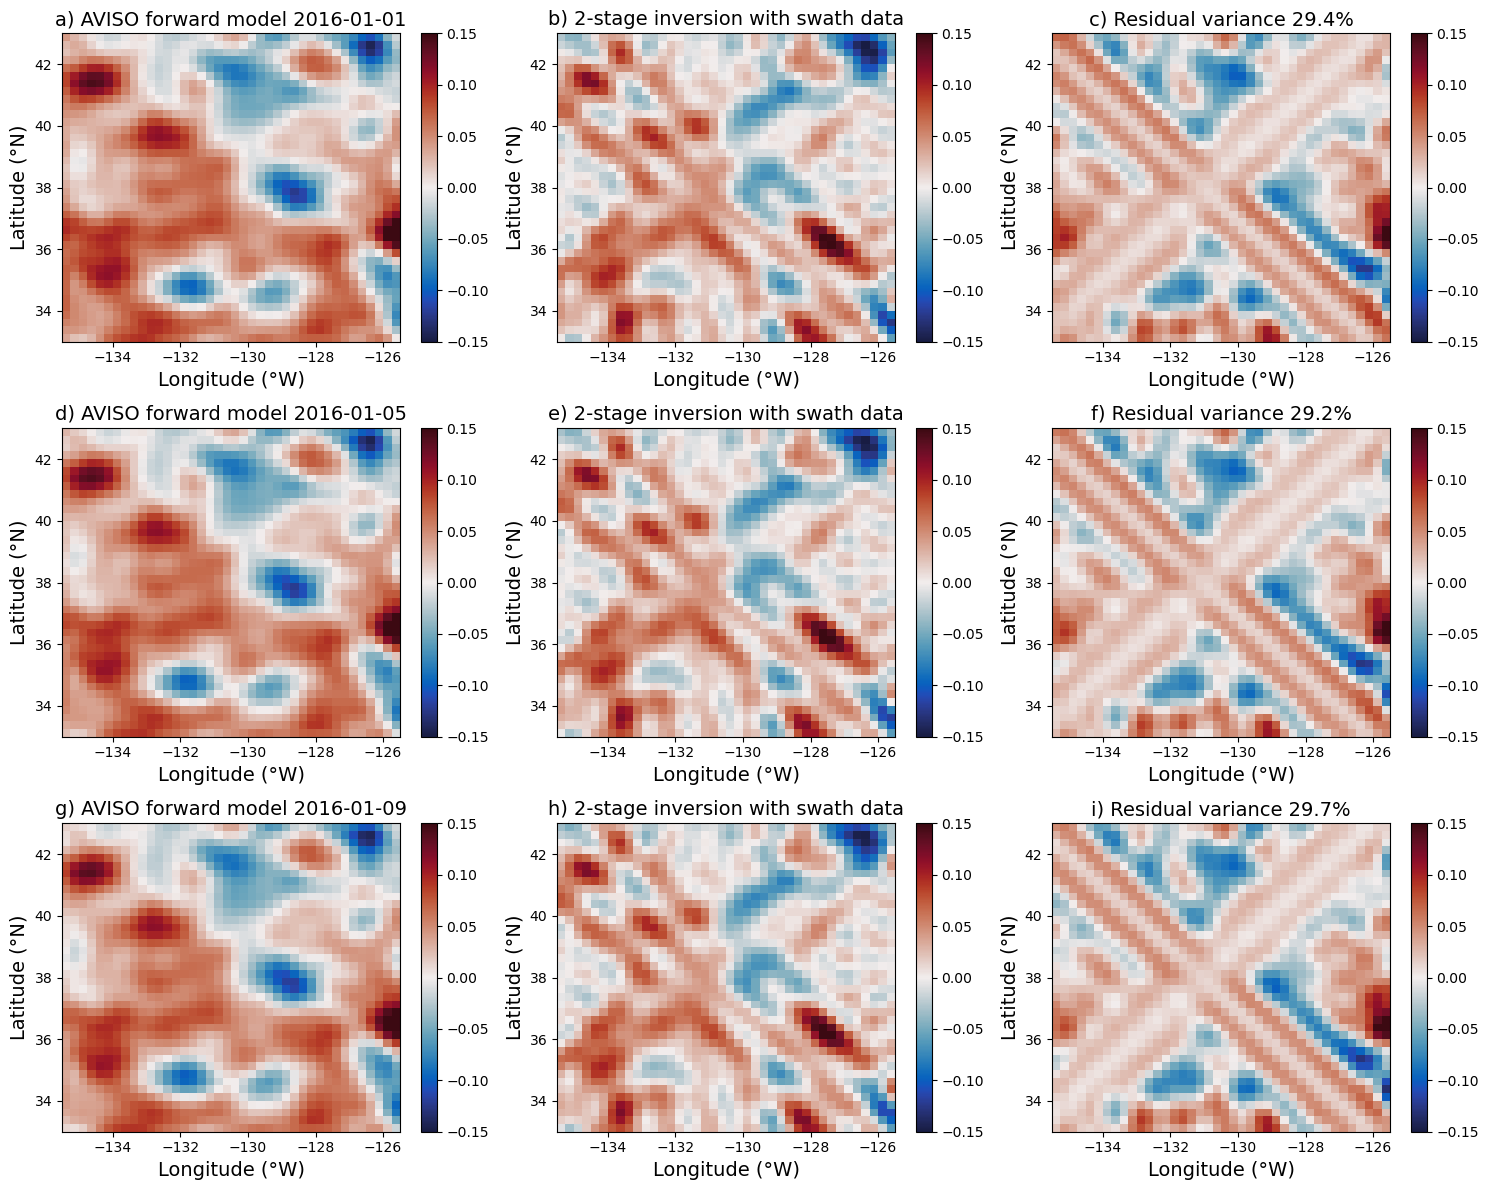

In [173]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_predicted1 = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true1 = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse2  = np.zeros(time_range)
variance_explained_inverse1  = np.zeros(time_range)
MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])

ind_list = list('abcdefghijklm')
count = 0
plt.figure(figsize = (15, 12))
for day in range(time_range):

    # SSH data
    #MSLA = SSHA_masked[:, :, day0+day: day0+day+1]
    MSLA = MSLA_fwd[:, :, day0+day: day0+day+1]
    # Build basis function H matrix
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0 - day0 + day)
    
    # forecast SSH
    SSHA_predicted1[day], SSHA_true1[day], variance_explained_inverse1[day] = forecast_ssh(MSLA, amp_swath[:380],  H_all)
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse2[day] = forecast_ssh(MSLA, amp_swath_2step,  H_all)
    # reverse vector
    MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])

    if (day % 4 ==0 and day < 12):
        plt.subplot(3, 3, count + 1)
        plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title(ind_list[count] + ') AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

        plt.subplot(3, 3, count + 2)
        plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title(ind_list[count+1] + ') 2-stage inversion with swath data', fontsize = 14)

        residual = MSLA[:, :, 0] - MSLA_fwrd[:, :, day] 
        plt.subplot(3, 3, count + 3)
        plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title(ind_list[count+2] +') Residual variance ' 
                  + str((variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
        count = count + 3
        plt.tight_layout()

plt.savefig('./ssh_swath' + str(date_time[day0 + day])[:10] +'_2stage.png', dpi = 300)

# Important parameter: Root mean squared correlated error and ssh

In [184]:
rms_err = np.sqrt(np.mean(cor_err**2))
rms_ssh = np.sqrt(np.mean(ssh**2))
sigma, rms_err, rms_err/ rms_ssh 

(0.0035, 0.016018481689884644, 0.29251026979052497)

In [185]:
# compute residual variance in and out of track
var_in2=np.zeros(time_range)
var_out2=np.zeros(time_range)
for i in range(time_range):
    msla_in=np.ma.masked_where(mask[:,:,0]==0, MSLA_fwd[:,:,i]) # mask in track points
    msla_out=np.ma.masked_where(mask[:,:,0]==1, MSLA_fwd[:,:,i]) # mask off track points
    var_in2[i]=np.mean(np.mean((MSLA_fwrd[:,:,i]-msla_in)**2,axis=1),axis=0)/(np.mean(np.mean(msla_in**2,axis=1),axis=0))
    var_out2[i]=np.mean(np.mean((MSLA_fwrd[:,:,i]-msla_out)**2,axis=1),axis=0)/(np.mean(np.mean(msla_out**2,axis=1),axis=0))

In [186]:
var_in_raw_2=np.zeros(time_range)
test_diff_2=np.zeros(time_range)
for i in range(time_range):
    msla_in=np.ma.masked_where(mask[:,:,0]==0,MSLA_fwd[:,:,i])
    msla_test=np.ma.masked_where(mask[:,:,0]==0,MSLA_fwrd[:,:,i])
    var_in_raw_2[i]=np.mean(np.mean((ssh_2step[:,:,i]- msla_in)**2,axis=1),axis=0)/(np.mean(np.mean(msla_in**2,axis=1),axis=0))
    test_diff_2[i]=np.mean(np.mean((ssh_2step[:,:,i]-msla_test)**2,axis=1),axis=0)/(np.mean(np.mean(msla_test**2,axis=1),axis=0))

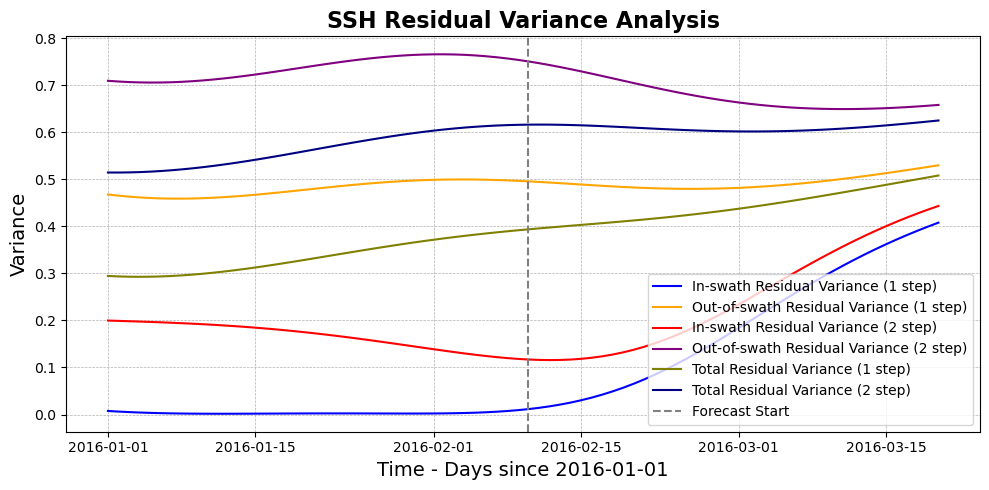

In [238]:
import matplotlib.pyplot as plt

# Set figure size and aspect ratio for landscape orientation
fig, ax = plt.subplots(figsize=(10, 5))

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy']

# Line plots
ax.plot(time, var_in, label='In-swath Residual Variance (1 step)', linewidth=1.5, color=colors[0])
ax.plot(time, var_out, label='Out-of-swath Residual Variance (1 step)', linewidth=1.5, color=colors[1])
ax.plot(time, var_in2, label='In-swath Residual Variance (2 step)', linewidth=1.5, color=colors[2])
ax.plot(time, var_out2, label='Out-of-swath Residual Variance (2 step)', linewidth=1.5, color=colors[3])
ax.plot(time, variance_explained_inverse1[0:], label='Total Residual Variance (1 step)', linewidth=1.5, color=colors[8])
ax.plot(time, variance_explained_inverse2[0:], label='Total Residual Variance (2 step)', linewidth=1.5, color=colors[9])

# Dashed vertical line at x = 40
ax.axvline(time[40], color='gray', linestyle='--', label="Forecast Start")

# Adjust plot properties for better clarity
ax.set_title('SSH Residual Variance Analysis', fontsize=16, fontweight='bold')
ax.set_xlabel('Time - Days since 2016-01-01', fontsize=14)
ax.set_ylabel('Variance', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position and size
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax.legend(loc='best', fontsize = 10)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()
plt.savefig('residual_variance.png', dpi=300)
plt.show()


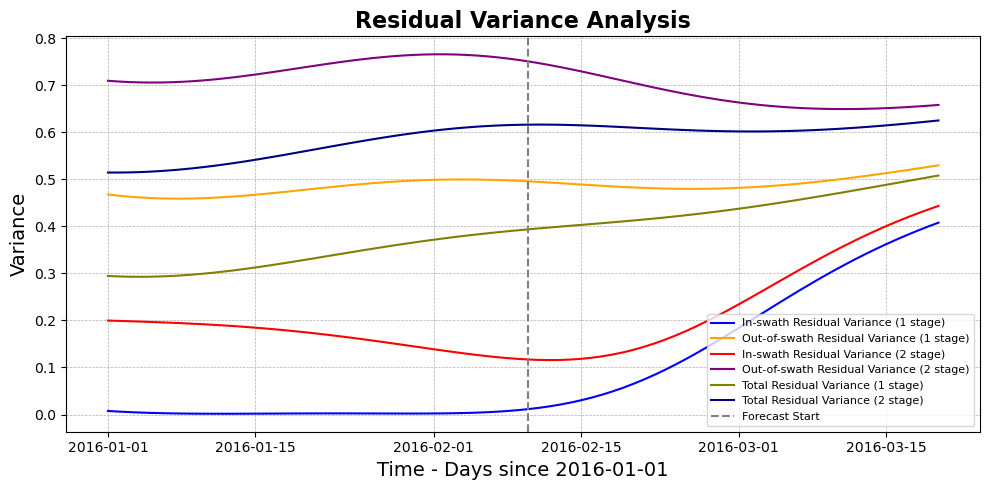

In [234]:
import matplotlib.pyplot as plt

# Set figure size and aspect ratio for landscape orientation
fig, ax = plt.subplots(figsize=(10, 5))

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy']

# Line plots
ax.plot(time, var_in, label='In-swath Residual Variance (1 stage)', linewidth=1.5, color=colors[0])
ax.plot(time, var_out, label='Out-of-swath Residual Variance (1 stage)', linewidth=1.5, color=colors[1])
ax.plot(time, var_in2, label='In-swath Residual Variance (2 stage)', linewidth=1.5, color=colors[2])
ax.plot(time, var_out2, label='Out-of-swath Residual Variance (2 stage)', linewidth=1.5, color=colors[3])
ax.plot(time, variance_explained_inverse1[0:], label='Total Residual Variance (1 stage)', linewidth=1.5, color=colors[8])
ax.plot(time, variance_explained_inverse2[0:], label='Total Residual Variance (2 stage)', linewidth=1.5, color=colors[9])

# Dashed vertical line at x = 40
ax.axvline(time[40], color='gray', linestyle='--', label="Forecast Start")

# Adjust plot properties for better clarity
ax.set_title('Residual Variance Analysis', fontsize=16, fontweight='bold')
ax.set_xlabel('Time - Days since 2016-01-01', fontsize=14)
ax.set_ylabel('Variance', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position and size
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax.legend(loc='best', fontsize = 8)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()
plt.savefig('residual_variance.png', dpi=300)
plt.show()


Note that "in swath" and "residual" solutions should match but don't because of double counting of crossover points.

# Important result: 2-stage error estimate skill and ssh estimate skill

In [188]:
(1-ssh_diff2.mean()) * 100, (1 - err_diff2.mean()) * 100

(nan, nan)

# Important result: 1-stage error estimate skill and ssh estimate skill

In [ ]:
(1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 #, (1 - ssh_diff_percent.mean()) * 100